# Vector Addition

In this tutorial, you will write a simple vector addition using Triton.<br>
In doing so, you will learn about:<br>
* The basic programming model of Triton.<br>
* The `triton.jit` decorator, which is used to define Triton kernels.<br>
* The best practices for validating and benchmarking your custom ops against native reference implementations.<br>


## Compute Kernel

In [1]:
import torch

In [2]:
import triton
import triton.language as tl

In [3]:
GPU_BLOCK_SIZE = 1024
CPU_BLOCK_SIZE = 4096
# Single Thread Threshold
CPU_ST_THRESHOLD = 65536
USE_GPU = False

In [4]:
@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

In [5]:
@triton.jit
def add_kernel_tiled(x_ptr,  # *Pointer* to first input vector.
                     y_ptr,  # *Pointer* to second input vector.
                     output_ptr,  # *Pointer* to output vector.
                     n_elements,  # Size of the vector.
                     BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
                     TILE_SIZE: tl.constexpr,  # Number of elements each iteration should process.
                     # NOTE `constexpr` so it can be used as a shape value.
                     ):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    for i in range(0, tl.cdiv(BLOCK_SIZE, TILE_SIZE)):
        offsets = block_start + i * TILE_SIZE + tl.arange(0, TILE_SIZE)
        mask = offsets < n_elements
        x = tl.load(x_ptr + offsets, mask=mask)
        y = tl.load(y_ptr + offsets, mask=mask)
        output = x + y
        tl.store(output_ptr + offsets, output, mask=mask)

In [6]:
@triton.autotune(
    configs=[
        # For small vectors it might be faster to use a single thread instead
        # of paying OMP threading overhead, so add a single-threaded option.
        # Other options use all available threads.
        triton.Config({'TILE_SIZE': 16, 'BLOCK_SIZE': 4096}, num_threads=1),
        triton.Config({'TILE_SIZE': 16, 'BLOCK_SIZE': 4096}, num_threads=0),
        triton.Config({'TILE_SIZE': 16, 'BLOCK_SIZE': 8192}, num_threads=0),
        triton.Config({'TILE_SIZE': 16, 'BLOCK_SIZE': 16384}, num_threads=0),
        triton.Config({'TILE_SIZE': 16, 'BLOCK_SIZE': 32768}, num_threads=0),
        triton.Config({'TILE_SIZE': 16, 'BLOCK_SIZE': 65536}, num_threads=0),
    ],
    key=['n_elements'],
)
@triton.jit
def add_kernel_tiled_autotuned(x_ptr,  # *Pointer* to first input vector.
                               y_ptr,  # *Pointer* to second input vector.
                               output_ptr,  # *Pointer* to output vector.
                               n_elements,  # Size of the vector.
                               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
                               TILE_SIZE: tl.constexpr,  # Number of elements each iteration should process.
                               ):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    for i in range(0, tl.cdiv(BLOCK_SIZE, TILE_SIZE)):
        offsets = block_start + i * TILE_SIZE + tl.arange(0, TILE_SIZE)
        mask = offsets < n_elements
        x = tl.load(x_ptr + offsets, mask=mask)
        y = tl.load(y_ptr + offsets, mask=mask)
        output = x + y
        tl.store(output_ptr + offsets, output, mask=mask)

Let's also declare a helper function to (1) allocate the `z` tensor
and (2) enqueue the above kernel with appropriate grid/block sizes:

In [7]:
def add(x: torch.Tensor, y: torch.Tensor, output: torch.Tensor, device):
    if output is None:
        # We need to preallocate the output.
        output = torch.empty_like(x)
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=CPU_BLOCK_SIZE if device == 'cpu' else GPU_BLOCK_SIZE)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [8]:
def add_tiled(x: torch.Tensor, y: torch.Tensor, output):
    if output is None:
        output = torch.empty_like(x)
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    add_kernel_tiled[grid](x, y, output, n_elements, BLOCK_SIZE=CPU_BLOCK_SIZE, TILE_SIZE=16)
    return output

In [9]:
def add_tiled_with_st_threshold(x: torch.Tensor, y: torch.Tensor, output):
    if output is None:
        output = torch.empty_like(x)
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # TODO: try to choose the best block size using autotuner
    BLOCK_SIZE = triton.next_power_of_2(n_elements)
    if BLOCK_SIZE > CPU_ST_THRESHOLD:
        BLOCK_SIZE = CPU_BLOCK_SIZE
    add_kernel_tiled[grid](x, y, output, n_elements, BLOCK_SIZE=BLOCK_SIZE, TILE_SIZE=16)
    return output

In [10]:
def add_tiled_autotuned(x: torch.Tensor, y: torch.Tensor, output):
    if output is None:
        output = torch.empty_like(x)
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    add_kernel_tiled_autotuned[grid](x, y, output, n_elements)
    return output

We can now use the above function to compute the element-wise sum of two `torch.tensor` objects and test its correctness:

In [11]:
torch.manual_seed(0)
size = 98432

In [12]:
triton.runtime.driver.set_active_to_cpu()
x = torch.rand(size, device='cpu')
y = torch.rand(size, device='cpu')
output_torch_cpu = torch.add(x, y)
output_triton_cpu = add(x, y, None, device='cpu')
print(output_torch_cpu)
print(output_triton_cpu)
print(f'The maximum difference between torch-cpu and triton-cpu is '
      f'{torch.max(torch.abs(output_torch_cpu - output_triton_cpu))}')
output_triton_cpu = add_tiled(x, y, None)
print(f'The maximum difference between torch-cpu-tiled and triton-cpu is '
      f'{torch.max(torch.abs(output_torch_cpu - output_triton_cpu))}')

tensor([0.5151, 1.6826, 0.9153,  ..., 0.9852, 1.2714, 1.8192])
tensor([0.5151, 1.6826, 0.9153,  ..., 0.9852, 1.2714, 1.8192])
The maximum difference between torch-cpu and triton-cpu is 0.0
The maximum difference between torch-cpu-tiled and triton-cpu is 0.0


In [13]:
LINE_VALS = [
    'triton-cpu', 'triton-cpu-hooks', 'triton-cpu-tiled', 'triton-cpu-tiled-hooks', 'triton-cpu-tiled-tuned-hooks',
    'triton-cpu-tiled-autotuned-hooks', 'torch-cpu'
]
LINE_NAMES = [
    'TritonCPU', 'TritonCPU (hooks)', 'TritonCPUTiled', 'TritonCPUTiled (hooks)', 'TritonCPUTiled (tuned, hooks)',
    'TritonCPUTiled (autotuned, hooks)', 'TorchCPU'
]
LINE_STYLES = [('blue', '--'), ('blue', '-.'), ('red', '-'), ('red', '--'), ('red', '-.'), ('red', ':'), ('green', '-')]

In [14]:
if USE_GPU and triton.runtime.driver.get_active_gpus():
    triton.runtime.driver.set_active_to_gpu()
    x = x.to('cuda')
    y = y.to('cuda')
    output_torch_gpu = x + y
    output_triton_gpu = add(x, y, None, device='cuda')
    print(output_torch_gpu)
    print(output_triton_gpu)
    print(f'The maximum difference between torch-gpu and triton-gpu is '
          f'{torch.max(torch.abs(output_torch_gpu - output_triton_gpu))}')
    LINE_VALS += ['triton-gpu', 'torch-gpu']
    LINE_NAMES += ['TritonGPU', 'TorchGPU']
    LINE_STYLES += [('yellow', '-'), ('red', '-')]

Seems like we're good to go!

## Benchmark
We can now benchmark our custom op on vectors of increasing sizes to get a sense of how it does relative to PyTorch.
To make things easier, Triton has a set of built-in utilities that allow us to concisely plot the performance of our custom ops.
for different problem sizes.

In [16]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=LINE_VALS,  # Possible values for `line_arg`.
        line_names=LINE_NAMES,  # Label name for the lines.
        styles=LINE_STYLES,  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name=
        # Name for the plot. Used also as a file name for saving the plot.
        f'vector-add-performance (CPU_BLOCK_SIZE={CPU_BLOCK_SIZE}, GPU_BLOCK_SIZE={GPU_BLOCK_SIZE})',
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    device = 'cpu' if 'cpu' in provider else 'cuda'
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)
    if device == 'cpu':
        triton.runtime.driver.set_active_to_cpu()
    else:
        triton.runtime.driver.set_active_to_gpu()
    output = torch.empty_like(x)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-gpu':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    elif provider == 'triton-gpu':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y, None, False), quantiles=quantiles)
    elif provider == 'torch-cpu':
        # Note that we preallocate the output buffer here to only measure the kernel performance
        # without a large chunk of memory allocation.
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.add(x, y, out=output), quantiles=quantiles)
    elif provider == 'triton-cpu':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y, output, device), quantiles=quantiles)
    elif provider == 'triton-cpu-hooks':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y, output, device), quantiles=quantiles,
                                                     measure_time_with_hooks=True)
    elif provider == 'triton-cpu-tiled':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_tiled(x, y, output), quantiles=quantiles)
    elif provider == 'triton-cpu-tiled-hooks':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_tiled(x, y, output), quantiles=quantiles,
                                                     measure_time_with_hooks=True)
    elif provider == 'triton-cpu-tiled-tuned-hooks':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_tiled_with_st_threshold(x, y, output),
                                                     quantiles=quantiles, measure_time_with_hooks=True)
    elif provider == 'triton-cpu-tiled-autotuned-hooks':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_tiled_autotuned(x, y, output), quantiles=quantiles,
                                                     measure_time_with_hooks=True)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

We can now run the decorated function above. Pass `print_data=True` to see the performance number, `show_plots=True` to plot them, and/or
`save_path='/path/to/results/' to save them to disk along with raw CSV data:

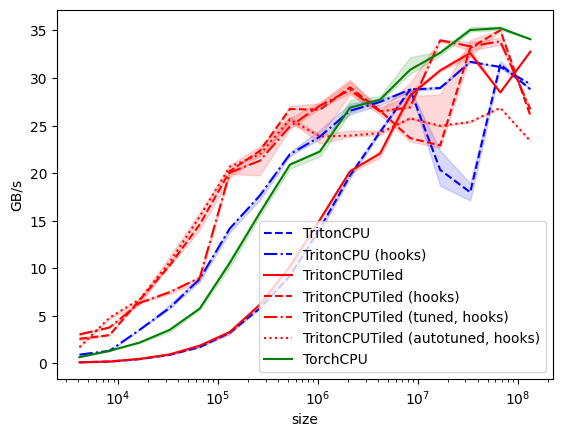

vector-add-performance (CPU_BLOCK_SIZE=4096, GPU_BLOCK_SIZE=1024):
           size  TritonCPU  TritonCPU (hooks)  TritonCPUTiled  TritonCPUTiled (hooks)  TritonCPUTiled (tuned, hooks)  TritonCPUTiled (autotuned, hooks)   TorchCPU
0        4096.0   0.092993           0.901285        0.099941                2.561876                       3.025051                           1.683490   0.632291
1        8192.0   0.172624           1.303258        0.179110                2.951482                       3.754501                           4.785362   1.303922
2       16384.0   0.430187           3.506661        0.454360                6.644411                       6.337433                           6.716284   2.167170
3       32768.0   0.885183           5.818524        0.927850               10.262696                       7.468953                          10.633200   3.507811
4       65536.0   1.687416           8.853827        1.848171               14.582559                       8.981620  

In [17]:
benchmark.run(print_data=True, show_plots=True)